## P2. Locally Weighted Regression

Similar to what we had in ordinary linear regression, we can write the matrix notation of loss and take the derivative of it w.r.t. the weights $w$. Note that we have:

$$\frac{1}{2} \sum_{i=1}^{n}a^{(i)}(y^{(i)} - \mathbf{w}^T\mathbf{x}^{(i)})^2 + \frac{\lambda}{2} ||\mathbf{w}|| ^ 2$$
$$= (y - \mathbf{X}w) A (y - \mathbf{X}w)^T + \frac{\lambda}{2} \mathbf{w}^T\mathbf{w}$$

We can simplify the first term as the following:

$$= (y - \mathbf{X}\mathbf{w})^T A (y - \mathbf{X}\mathbf{w})$$
$$= (y^T - \mathbf{w}^T\mathbf{X}^T) A (y - \mathbf{X}\mathbf{w})$$
$$= (y^TAy - \mathbf{w}^T\mathbf{X}^T A y - y^T A \mathbf{X}\mathbf{w} + \mathbf{w}^T\mathbf{X}^TA \mathbf{X}\mathbf{w})$$

Note that $\mathbf{w}^T\mathbf{X}^T A y$ and $y^T A \mathbf{X}\mathbf{w}$ are $1 \times 1$ matrices and transpose of each other. Therefore they are equal. Thus we can write $\mathbf{w}^*$ as following:

$$\mathbf{w}^* = argmin \frac{1}{2}(y^TAy - 2\mathbf{w}^T\mathbf{X}^T A y + \mathbf{w}^T\mathbf{X}^TA \mathbf{X}\mathbf{w}) + \frac{\lambda}{2} \mathbf{w}^T\mathbf{w}$$.


To solve it, we can take the derivative w.r.t. $\mathbf{w}$ and set it equal to zero:

$$\mathbf{X}^TA \mathbf{X}\mathbf{w} + \lambda \mathbf{w} = \mathbf{X}^T A y$$

Thus:
$$(\mathbf{X}^TA \mathbf{X} + \lambda \mathbf{I})\mathbf{w} = \mathbf{X}^T A y$$

We can easily multiply both sides by $(\mathbf{X}^TA \mathbf{X} + \lambda \mathbf{I})^{-1}$ and get the formula for $\mathbf{w}^*$.


Note: I have copied the code of q2.py here as well.

  0%|          | 1/200 [00:00<02:52,  1.16it/s]

Validation loss: 5269.391638980311
Train loss: 233.33631815494945


100%|██████████| 200/200 [03:08<00:00,  1.06it/s]


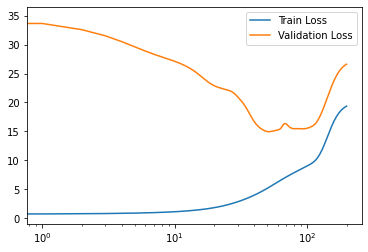

In [1]:
# -*- coding: utf-8 -*-
"""
Created on Tue Sep 12 20:39:09 2017

"""
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_boston
from scipy.special import logsumexp
from tqdm import tqdm 

np.random.seed(0)

# load boston housing prices dataset
boston = load_boston()
x = boston['data']
N = x.shape[0]
x = np.concatenate((np.ones((506,1)),x),axis=1) #add constant one feature - no bias needed
d = x.shape[1]
y = boston['target']

idx = np.random.permutation(range(N))

#helper function
def l2(A,B):
    '''
    Input: A is a Nxd matrix
           B is a Mxd matirx
    Output: dist is a NxM matrix where dist[i,j] is the square norm between A[i,:] and B[j,:]
    i.e. dist[i,j] = ||A[i,:]-B[j,:]||^2
    '''
    A_norm = (A**2).sum(axis=1).reshape(A.shape[0],1)
    B_norm = (B**2).sum(axis=1).reshape(1,B.shape[0])
    dist = A_norm+B_norm-2*A.dot(B.transpose())
    return dist

 
def LRLS(test_datum,x_train,y_train, tau,lam=1e-5):
    '''
    Input: test_datum is a dx1 test vector
           x_train is the N_train x d design matrix
           y_train is the N_train x 1 targets vector
           tau is the local reweighting parameter
           lam is the regularization parameter
    output is y_hat the prediction on test_datum
    '''
    ## TODO
    n_train = x_train.shape[0]

    a = -l2(test_datum.reshape(1, -1), x_train) / (2 * tau ** 2)  # shape: (1, N)
    a -= np.max(a)  # shape: (1, N)
    a = np.exp(a - logsumexp(a))  # shape: (1, N)
    
    A = np.eye(n_train) * a  # shape: (N, N)

    w_star = np.linalg.inv(x_train.T @ A @ x_train + lam * np.eye(d)) @ x_train.T @ A @ y_train

    return test_datum.T @ w_star
    ## TODO


def run_validation(x,y,taus,val_frac):
    '''
    Input: x is the N x d design matrix
           y is the N x 1 targets vector    
           taus is a vector of tau values to evaluate
           val_frac is the fraction of examples to use as validation data
    output is
           a vector of training losses, one for each tau value
           a vector of validation losses, one for each tau value
    '''
    ## TODO
    val_idx, train_idx = idx[:int(val_frac * N)], idx[int(val_frac * N):]
    x_val, y_val = x[val_idx], y[val_idx]
    x_train, y_train = x[train_idx], y[train_idx]
    
    losses_train = []
    losses_val = []

    with tqdm(total=len(taus)) as pbar:
        for tau in taus:
            loss_val = 0.
            for test_datum, t in zip(x_val, y_val):
                y_hat = LRLS(test_datum, x_train, y_train, tau)
                loss_val += (y_hat - t) ** 2
            losses_val.append(loss_val/len(x_val))

            loss_train = 0.
            for test_datum, t in zip(x_train, y_train):
                y_hat = LRLS(test_datum, x_train, y_train, tau)
                loss_train += (y_hat - t) ** 2
            losses_train.append(loss_train/len(x_train))
            
            if tau == 10.:
                print('Validation loss:', loss_val)
                print('Train loss:', loss_train)
            
            pbar.update(1)

    return losses_train, losses_val
    ## TODO



# In this excersice we fixed lambda (hard coded to 1e-5) and only set tau value. Feel free to play with lambda as well if you wish
taus = np.logspace(1.0,3,200)
train_losses, test_losses = run_validation(x,y,taus,val_frac=0.3)
plt.semilogx(train_losses, label='Train Loss')
plt.semilogx(test_losses, label='Validation Loss')
plt.legend()
plt.show()


For $\tau=10$, validation loss is 5269.39 and training loss is 233.33.

As the plot shows, the training loss curve first comes down and then goes up. This stems from the fact that for very small values of $\tau$, we have overfitting since we just consider only close neighbors to a given data point (weights of closer points are much bigger than the weights of farther points). When $\tau$ is very big, we have underfitting since the weights of different data points (far and close) become approximately equal. This setting is analogus to the ordinary linear regression where we have underfitting and cannot capture local linearities. However, somewhere in between we will have the best results where the model neither overfits nor underfits.